# Heart Failure mortality prediction with Multilayer perceptron for classification 

# Project BG

Create a Multilayer perceptron model for predicting mortality caused by Heart Failure.

Cardiovascular diseases are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

**Observations from EDA:**
- class imbalance: need to use smote
- time and death event are negatively correlated

**Model contains:**
- Multilayer perceptron
- SMOTE 
- Early Stopping
- Learning Rate Scheduling

**Content of Dataset**
299 participants and 13 columns

- anaemia                  
- creatinine_phosphokinase  
- diabetes                  
- ejection_fraction         
- high_blood_pressure       
- platelets                 
- serum_creatinine          
- serum_sodium               
- sex                         
- smoking                     
- time                        
- DEATH_EVENT

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import Counter
import seaborn as sns

2024-04-26 14:15:24.440000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 14:15:24.440189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 14:15:24.623394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


# Load data and EDA 

In [3]:
data=pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

In [4]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [6]:
# Count the classes in the dataset
print('Classes and number of values in the dataset:', Counter(data['DEATH_EVENT']))

Classes and number of values in the dataset: Counter({0: 203, 1: 96})


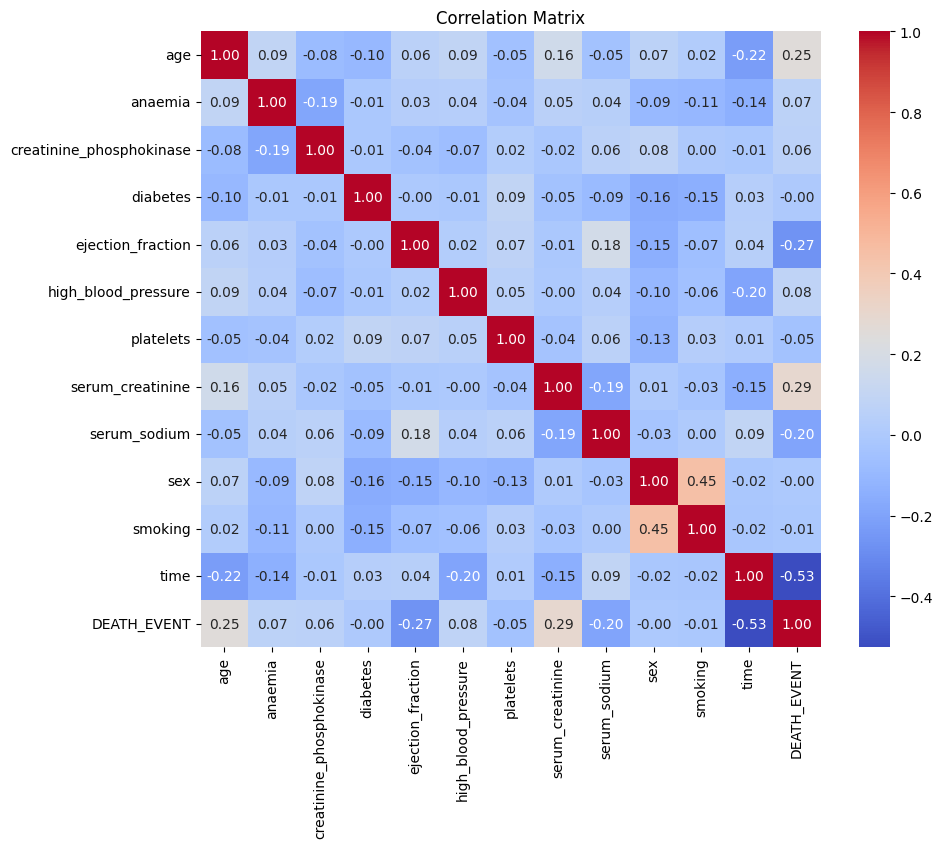

In [7]:
#calculate correlation matrix of all columns and plot it
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Interestingly, time seems to be negatively correlated with death event more than any other factor.

# Pipeline

In [8]:
# Separate features (X) and target variable (y)
y = data['DEATH_EVENT']
x = data.drop(['DEATH_EVENT'], axis=1)

In [9]:
# Convert categorical features to dummy variables
x = pd.get_dummies(x)

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23)

In [11]:
#normalisation: standardize numeric features
numeric_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 
                    'serum_creatinine', 'serum_sodium', 'time']

ct = ColumnTransformer([("numeric", StandardScaler(), numeric_features)])
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [12]:
# Define the neural network model
model = Sequential()
model.add(InputLayer(shape=(X_train.shape[1],)))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [13]:
# Compile the model with a specified initial learning rate
initial_learning_rate = 0.01
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define a learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * float(tf.math.exp(-0.1).numpy())

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

In [14]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [15]:
# Create a SMOTE object
smote = SMOTE(random_state=23)

# Define a pipeline that first applies SMOTE and then fits the model
pipeline = ImbPipeline([
    ('smote', smote),
    ('model', model)
])

In [16]:
# Train the model with early stopping and learning rate scheduler
history = pipeline.fit(
    X_train,
    y_train,
    model__epochs=100,
    model__batch_size=16,
    model__verbose=1,
    model__validation_data=(X_test, y_test),
    model__callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7302 - loss: 0.5455 - val_accuracy: 0.7000 - val_loss: 0.5362 - learning_rate: 0.0100
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8263 - loss: 0.4071 - val_accuracy: 0.7333 - val_loss: 0.4846 - learning_rate: 0.0100
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8567 - loss: 0.3435 - val_accuracy: 0.7667 - val_loss: 0.4869 - learning_rate: 0.0100
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8796 - loss: 0.2913 - val_accuracy: 0.7889 - val_loss: 0.4935 - learning_rate: 0.0100
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8982 - loss: 0.2945 - val_accuracy: 0.7778 - val_loss: 0.5056 - learning_rate: 0.0100
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9009 - loss: 0.2743 - val_accuracy: 0.7778 - val_loss: 0.5159 - learning_rate: 0.0100
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8892 - loss: 0.3063 - val_ac

# Evaluation

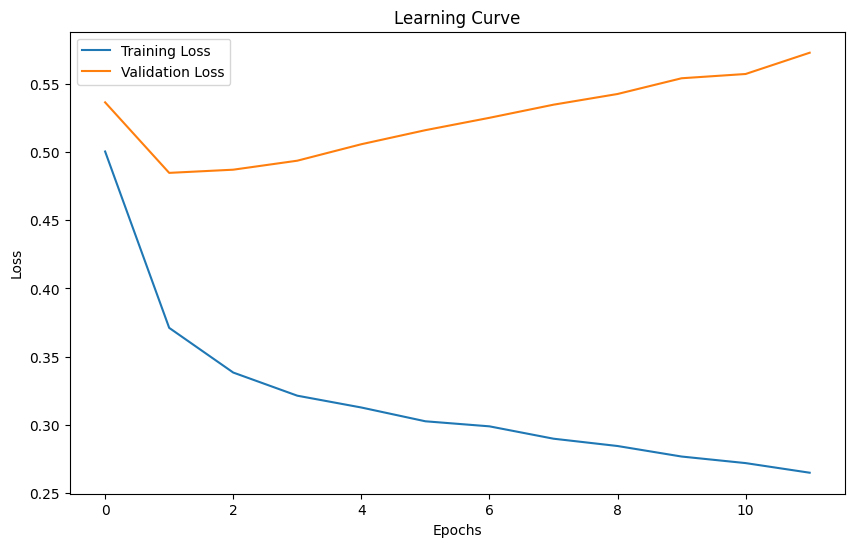

In [17]:
# Function to plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
# Plot the learning curve using the 'history' attribute of the model within the pipeline
plot_learning_curve(pipeline.named_steps['model'].history)

In [18]:
# Generate predictions on the test set
y_pred = (pipeline.predict(X_test) > 0.5).astype(int).flatten()

# Calculate performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        58
           1       0.62      0.66      0.64        32

    accuracy                           0.73        90
   macro avg       0.71      0.72      0.71        90
weighted avg       0.74      0.73      0.74        90



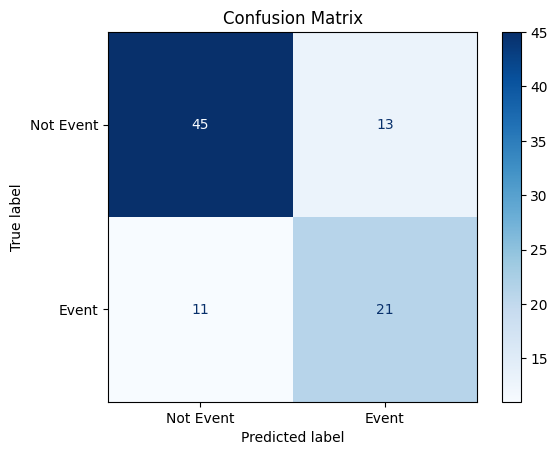

In [19]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Event', 'Event'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [20]:
print(cm)

[[45 13]
 [11 21]]


# Summary

The multilayer perceptron model has shown promising results, yet there are opportunities for enhancement. After experimenting with various configurations, the current iteration appears to be the most effective, though it's not without its imperfections. 

1. Metrics for classification:
    - Precision for the negative class (0) is quite good at 0.85, which means that when the model predicts no event, it is correct 85% of the time.
    - Recall for the negative class is also strong at 0.81, suggesting the model is good at capturing the majority of actual no-event cases.
    - Precision for the positive class (1) is lower at 0.69, indicating there are more false positives for the event class.
    - Recall for the positive class is better than precision at 0.75, showing that the model is reasonably good at capturing the event occurrences.
    - The overall accuracy of the model is 0.79, which is decent, but there is room for improvement, particularly in balancing precision and recall for the positive class.
    
**Since the importance of the initial question is how to predict which patients will die from heart feailure (so that physicians can identify this patients and intensify treatment efforts to avoid death), future plans for this project should be focused on improving detection of class 1.**

2. Confusion Matrix: The confusion matrix with 47 true negatives and 24 true positives indicates a reasonable performance. There are 11 false positives and 8 false negatives, showing a slightly higher number of cases where the model predicts an event when there wasn't one.

3. Learning Curve: The training loss continues to decline, which is good. However, the validation loss starts to increase after a few epochs, which could suggest the model begins to overfit the training data around that point. The early stopping seems to have worked correctly, as it stops the training early before overfitting gets worse.

# Next Steps:
To improve the outcome we could consider: 
- Using grid search or random search to optimize the model's parameters (hyperparameter tuning).
- Perform Feature Importance.
- Test other models: ensemble methods, gradient boosting methods...
